<a href="https://colab.research.google.com/github/bettercalln1ck/My_machine_learning_collab_files/blob/main/Mini_project_sem7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
#import utils
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

# To set the backend of matplotlib to the 'inline' backend
#%matplotlib inline

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras import losses
from tensorflow.python.client import device_lib
from tensorflow.keras.models import model_from_json
import cv2
from sklearn.metrics import classification_report, confusion_matrix
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r '/content/drive/MyDrive/data.zip' '/content'
!unzip data.zip 

Archive:  data.zip
   creating: data/
   creating: data/test/
   creating: data/test/healthy/
  inflating: data/test/healthy/20200610_063507.jpg  
  inflating: data/test/healthy/20200610_063534.jpg  
  inflating: data/test/healthy/20200610_063709.jpg  
  inflating: data/test/healthy/20200610_063729.jpg  
  inflating: data/test/healthy/20200610_063809.jpg  
  inflating: data/test/healthy/20200610_063813.jpg  
  inflating: data/test/healthy/20200610_063824.jpg  
  inflating: data/test/healthy/20200610_063828.jpg  
  inflating: data/test/healthy/20200610_063844.jpg  
  inflating: data/test/healthy/20200610_064024.jpg  
  inflating: data/test/healthy/20200610_064029.jpg  
  inflating: data/test/healthy/20200610_064049.jpg  
  inflating: data/test/healthy/20200610_064102.jpg  
  inflating: data/test/healthy/20200610_064133.jpg  
  inflating: data/test/healthy/20200610_064159.jpg  
  inflating: data/test/healthy/20200610_064258.jpg  
  inflating: data/test/healthy/20200610_064314.jpg  
  inf

In [4]:
class FixedImageDataGenerator(ImageDataGenerator):
    def standardize(self, x):
        if self.featurewise_center:
            x = ((x/255.) - 0.5) * 2.
        return x
    
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     horizontal_flip=True)

img_height = 224
img_width = 224
batch_size = 64

datagen_train = ImageDataGenerator(**data_gen_args)
train_generator = datagen_train.flow_from_directory("data/train/",
                                                    target_size=(img_height,img_height),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(**data_gen_args)
validation_generator = datagen_validation.flow_from_directory("data/test/",
                                                    target_size=(img_height,img_width),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)
print(train_generator)

Found 3380 images belonging to 2 classes.
Found 845 images belonging to 2 classes.


### Train and Test InceptionV3

In [ ]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top = False, input_shape = (img_height,img_width,3))
for layer in base_model.layers:
  layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(1000, activation='relu')(x)
predictions = Dense(2, activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
opt = Adam(learning_rate=0.0005)
head_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])



head_model.summary()


87924736/87910968 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)             

In [ ]:
# Let us train the Model 15 times
epochs = 60

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Create a Callback which reduces the Learning rate by a factor of "0.1" when the val_loss does not decrease
# after 2 epochs also and allowing the minimum value of Learning Rate to be 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')


# Create another Callback which saves the Model Weights by monitoring the Val_Accuracy
checkpoint = ModelCheckpoint("model_weights_cnn_64.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)


# A callback is an object that can perform actions at various stages of training
# (e.g. at the start or end of an epoch, before or after a single batch, etc).
callbacks = [checkpoint, reduce_lr]

# Fitting the model .
history = head_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/60
52/52 [==============================] - ETA: 0s - loss: 96.6621 - accuracy: 0.5829
Epoch 00001: saving model to model_weights_cnn_64.h5
52/52 [==============================] - 33s 494ms/step - loss: 96.6621 - accuracy: 0.5829 - val_loss: 0.8614 - val_accuracy: 0.7428 - lr: 5.0000e-04
Epoch 2/60
52/52 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.7491
Epoch 00002: saving model to model_weights_cnn_64.h5
52/52 [==============================] - 22s 424ms/step - loss: 0.7423 - accuracy: 0.7491 - val_loss: 0.6328 - val_accuracy: 0.7837 - lr: 5.0000e-04
Epoch 3/60
52/52 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.7708
Epoch 00003: saving model to model_weights_cnn_64.h5
52/52 [==============================] - 22s 421ms/step - loss: 0.6680 - accuracy: 0.7708 - val_loss: 0.8076 - val_accuracy: 0.7476 - lr: 5.0000e-04
Epoch 4/60
52/52 [==============================] - ETA: 0s - loss: 0.5167 - accuracy: 0.8115
Epoch 00004: sav

In [ ]:
#Confution Matrix and Classification Report
Y_pred = head_model.predict_generator(validation_generator,validation_generator.n//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Infected','Not Infected']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Confusion Matrix
[[340  60]
 [ 84 361]]
Classification Report
              precision    recall  f1-score   support

    Infected       0.80      0.85      0.83       400
Not Infected       0.86      0.81      0.83       445

    accuracy                           0.83       845
   macro avg       0.83      0.83      0.83       845
weighted avg       0.83      0.83      0.83       845



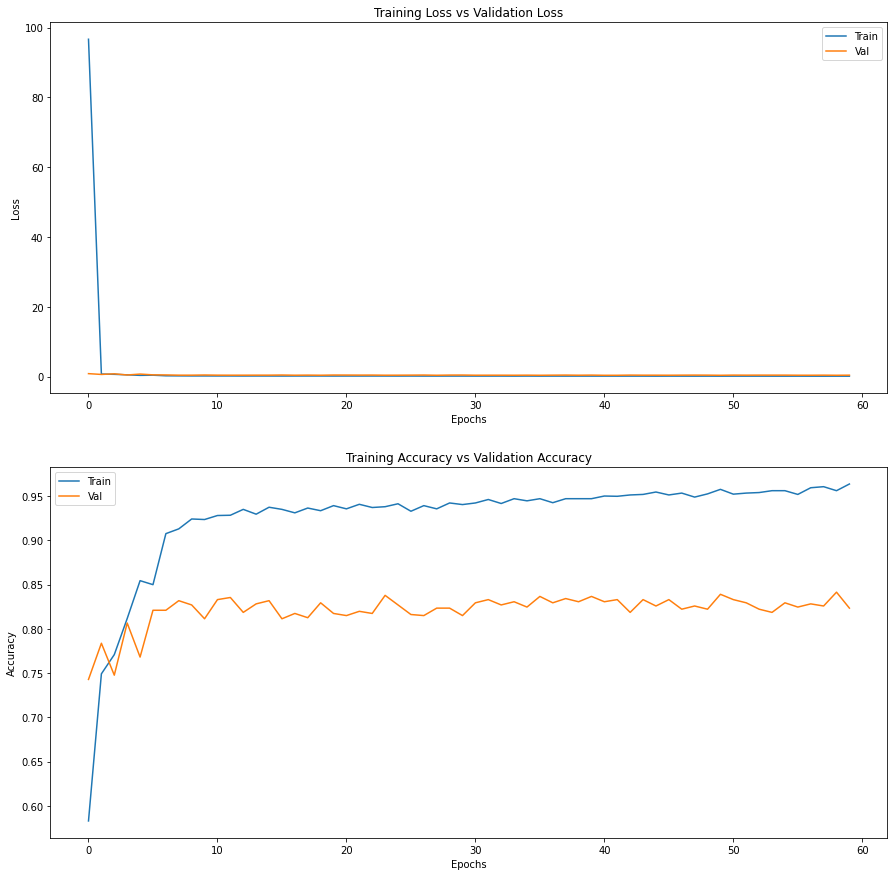

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

### Train and test RESNET 50

In [ ]:
base_model = tf.keras.applications.ResNet152(weights=None, include_top = False, input_shape =(img_height,img_width,3))
for layer in base_model.layers:
  layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(1000, activation='relu')(x)
predictions = Dense(2, activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
opt = Adam(learning_rate=0.0005)
head_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])



head_model.summary()



234708992/234698864 [==============================] - 5s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                         

In [ ]:
# Let us train the Model 15 times
epochs = 60

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Create a Callback which reduces the Learning rate by a factor of "0.1" when the val_loss does not decrease
# after 2 epochs also and allowing the minimum value of Learning Rate to be 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')


# Create another Callback which saves the Model Weights by monitoring the Val_Accuracy
checkpoint = ModelCheckpoint("model_weights_resnet_128.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)


# A callback is an object that can perform actions at various stages of training
# (e.g. at the start or end of an epoch, before or after a single batch, etc).
callbacks = [checkpoint, reduce_lr]

# Fitting the model .
history = head_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/60
52/52 [==============================] - ETA: 0s - loss: 5.1632 - accuracy: 0.8797
Epoch 00001: saving model to model_weights_resnet_128.h5
52/52 [==============================] - 146s 1s/step - loss: 5.1632 - accuracy: 0.8797 - val_loss: 0.2972 - val_accuracy: 0.9399 - lr: 5.0000e-04
Epoch 2/60
52/52 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9768
Epoch 00002: saving model to model_weights_resnet_128.h5
52/52 [==============================] - 73s 1s/step - loss: 0.0705 - accuracy: 0.9768 - val_loss: 0.1645 - val_accuracy: 0.9579 - lr: 5.0000e-04
Epoch 3/60
52/52 [==============================] - ETA: 0s - loss: 0.0392 - accuracy: 0.9870
Epoch 00003: saving model to model_weights_resnet_128.h5
52/52 [==============================] - 73s 1s/step - loss: 0.0392 - accuracy: 0.9870 - val_loss: 0.0654 - val_accuracy: 0.9712 - lr: 5.0000e-04
Epoch 4/60
18/52 [=========>....................] - ETA: 36s - loss: 0.0139 - accuracy: 0.9948

KeyboardInterrupt: ignored

In [ ]:
#Confution Matrix and Classification Report
Y_pred = head_model.predict_generator(validation_generator,validation_generator.n//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Infected','Not Infected']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[319  81]
 [ 61 384]]
Classification Report
              precision    recall  f1-score   support

    Infected       0.84      0.80      0.82       400
Not Infected       0.83      0.86      0.84       445

    accuracy                           0.83       845
   macro avg       0.83      0.83      0.83       845
weighted avg       0.83      0.83      0.83       845



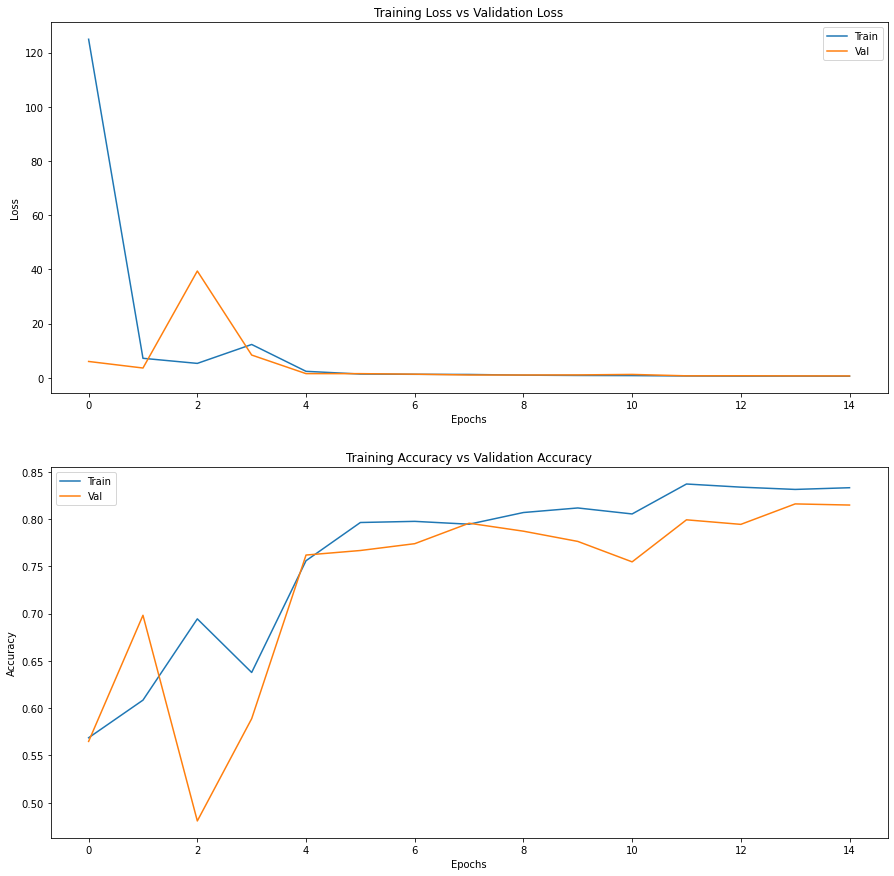

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

### Custom Model 2

In [5]:
def model_2( classes=2):
    model= tf.keras.models.Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(img_height,img_width,3)))
    model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    

    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    #Faltten the model
    model.add(Flatten())
    
    
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(classes, activation='softmax'))
    opt = Adam(lr=0.0001 , decay=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary
    return model
model_2 = model_2()
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      18496     
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 64)      0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


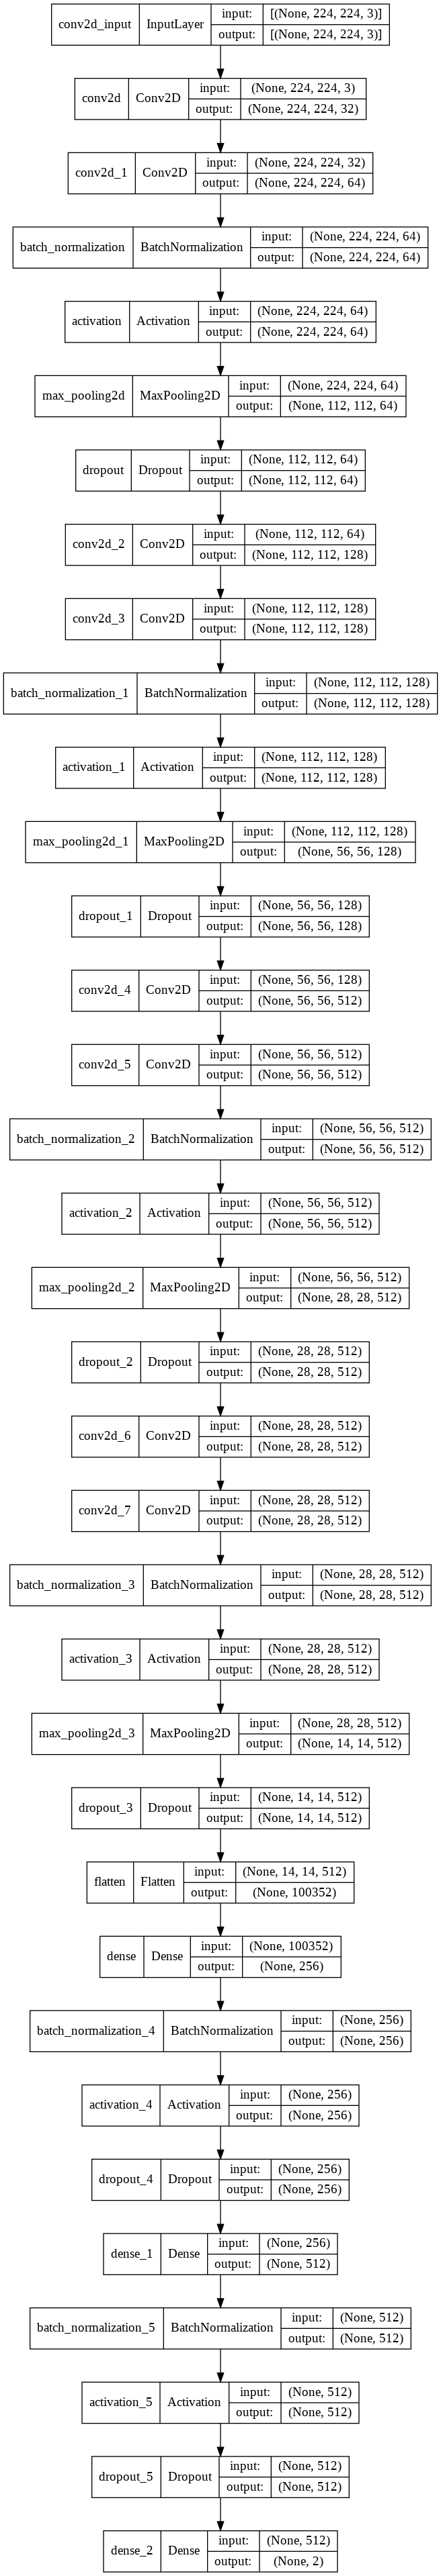

In [ ]:
plot_model(model_2, to_file='custom_model.png', show_shapes=True, show_layer_names=True)

In [6]:
chk_path_2 = 'model_2.h5'

# Let us train the Model 15 times
epochs = 60

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

checkpoint_2 = ModelCheckpoint(filepath=chk_path_2,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop_2 = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback_2 = tf.keras.callbacks.TensorBoard( histogram_freq=1)
csv_logger_2 = CSVLogger('training.log')

callback_2 = [checkpoint_2, reduce_lr_2, csv_logger_2]

In [ ]:
model_2_history = model_2.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=60,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callback_2
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/60
 1/52 [..............................] - ETA: 2:29:19 - loss: 18.3506 - accuracy: 0.4375

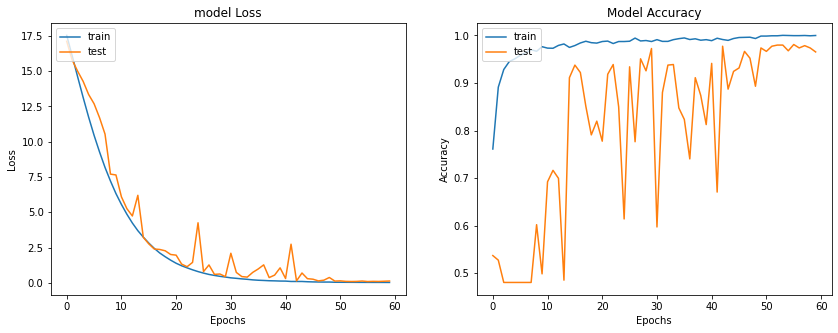

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(model_2_history.history['accuracy'])
plt.plot(model_2_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(model_2_history.history['loss'])
plt.plot(model_2_history.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model_2.predict_generator(validation_generator,validation_generator.n//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Infected','Not Infected']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Confusion Matrix
[[ 95 305]
 [ 61 384]]
Classification Report
              precision    recall  f1-score   support

    Infected       0.61      0.24      0.34       400
Not Infected       0.56      0.86      0.68       445

    accuracy                           0.57       845
   macro avg       0.58      0.55      0.51       845
weighted avg       0.58      0.57      0.52       845



### Train and Test DenseNet

In [ ]:
base_model = tf.keras.applications.DenseNet121(weights='imagenet', include_top = False, input_shape =(img_height,img_width,3))
for layer in base_model.layers:
  layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(1000, activation='relu')(x)
predictions = Dense(2, activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
opt = Adam(learning_rate=0.0005)
head_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])



head_model.summary()


29097984/29084464 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

In [ ]:
# Let us train the Model 15 times
epochs = 60

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Create a Callback which reduces the Learning rate by a factor of "0.1" when the val_loss does not decrease
# after 2 epochs also and allowing the minimum value of Learning Rate to be 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')


# Create another Callback which saves the Model Weights by monitoring the Val_Accuracy
checkpoint = ModelCheckpoint("model_weights_resnet_128.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)


# A callback is an object that can perform actions at various stages of training
# (e.g. at the start or end of an epoch, before or after a single batch, etc).
callbacks = [checkpoint, reduce_lr]

# Fitting the model .
history = head_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/60
52/52 [==============================] - ETA: 0s - loss: 1.4909 - accuracy: 0.8604
Epoch 00001: saving model to model_weights_resnet_128.h5
52/52 [==============================] - 30s 574ms/step - loss: 1.4909 - accuracy: 0.8604 - val_loss: 0.4855 - val_accuracy: 0.9171 - lr: 5.0000e-04
Epoch 2/60
52/52 [==============================] - ETA: 0s - loss: 0.4019 - accuracy: 0.9122
Epoch 00002: saving model to model_weights_resnet_128.h5
52/52 [==============================] - 27s 526ms/step - loss: 0.4019 - accuracy: 0.9122 - val_loss: 0.2942 - val_accuracy: 0.9171 - lr: 5.0000e-04
Epoch 3/60
52/52 [==============================] - ETA: 0s - loss: 0.2053 - accuracy: 0.9385
Epoch 00003: saving model to model_weights_resnet_128.h5
52/52 [==============================] - 27s 526ms/step - loss: 0.2053 - accuracy: 0.9385 - val_loss: 0.1643 - val_accuracy: 0.9447 - lr: 5.0000e-04
Epoch 4/60
52/52 [==============================] - ETA: 0s - loss: 0.1635 - accuracy: 0.9496
Epoch 

In [ ]:
#Confution Matrix and Classification Report
Y_pred = head_model.predict_generator(validation_generator,validation_generator.n//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Infected','Not Infected']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Confusion Matrix
[[389  11]
 [ 22 423]]
Classification Report
              precision    recall  f1-score   support

    Infected       0.95      0.97      0.96       400
Not Infected       0.97      0.95      0.96       445

    accuracy                           0.96       845
   macro avg       0.96      0.96      0.96       845
weighted avg       0.96      0.96      0.96       845



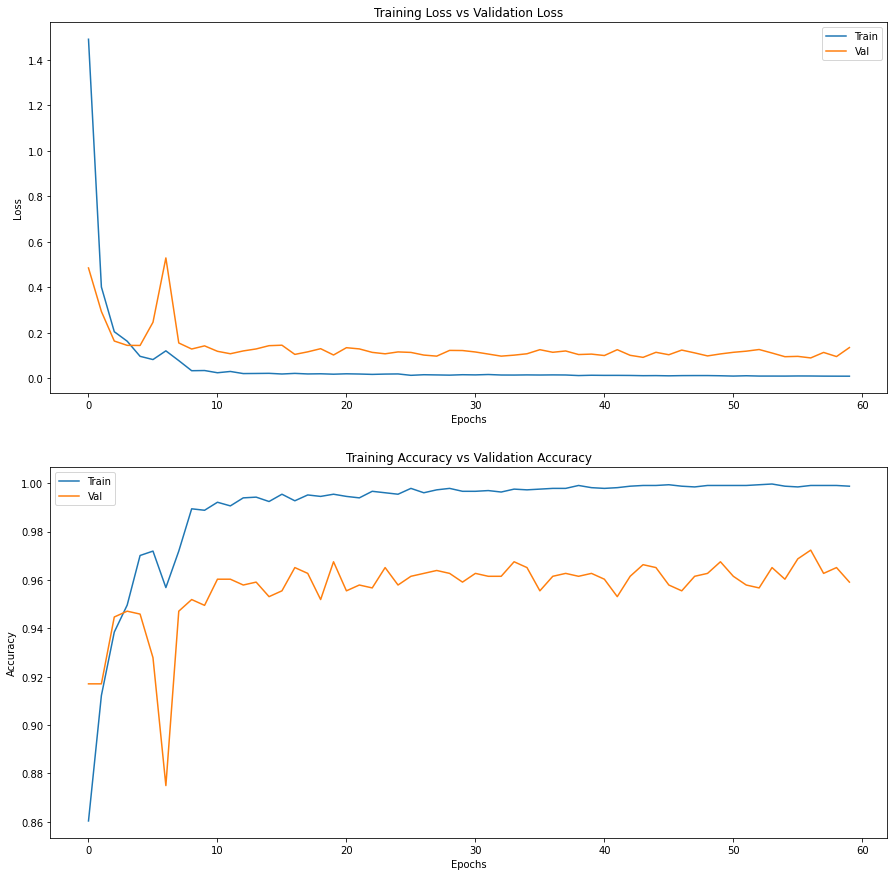

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

### Train and test VGG16

In [ ]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top = False, input_shape =(img_height,img_width,3))
for layer in base_model.layers:
  layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(1000, activation='relu')(x)
predictions = Dense(2, activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
opt = Adam(learning_rate=0.0005)
head_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])



head_model.summary()


58900480/58889256 [==============================] - 1s 0us/step
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
# Let us train the Model 15 times
epochs = 60

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Create a Callback which reduces the Learning rate by a factor of "0.1" when the val_loss does not decrease
# after 2 epochs also and allowing the minimum value of Learning Rate to be 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')


# Create another Callback which saves the Model Weights by monitoring the Val_Accuracy
checkpoint = ModelCheckpoint("model_weights_resnet_128.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)


# A callback is an object that can perform actions at various stages of training
# (e.g. at the start or end of an epoch, before or after a single batch, etc).
callbacks = [checkpoint, reduce_lr]

# Fitting the model .
history = head_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/60
52/52 [==============================] - ETA: 0s - loss: 13.0509 - accuracy: 0.7304
Epoch 00001: saving model to model_weights_resnet_128.h5
52/52 [==============================] - 62s 906ms/step - loss: 13.0509 - accuracy: 0.7304 - val_loss: 0.2253 - val_accuracy: 0.9050 - lr: 5.0000e-04
Epoch 2/60
52/52 [==============================] - ETA: 0s - loss: 0.1248 - accuracy: 0.9481
Epoch 00002: saving model to model_weights_resnet_128.h5
52/52 [==============================] - 32s 620ms/step - loss: 0.1248 - accuracy: 0.9481 - val_loss: 0.1222 - val_accuracy: 0.9591 - lr: 5.0000e-04
Epoch 3/60
52/52 [==============================] - ETA: 0s - loss: 0.0540 - accuracy: 0.9816
Epoch 00003: saving model to model_weights_resnet_128.h5
52/52 [==============================] - 32s 618ms/step - loss: 0.0540 - accuracy: 0.9816 - val_loss: 0.1274 - val_accuracy: 0.9555 - lr: 5.0000e-04
Epoch 4/60
52/52 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9891
Epoc

In [ ]:
#Confution Matrix and Classification Report
Y_pred = head_model.predict_generator(validation_generator,validation_generator.n//validation_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Infected','Not Infected']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Confusion Matrix
[[380  20]
 [  8 437]]
Classification Report
              precision    recall  f1-score   support

    Infected       0.98      0.95      0.96       400
Not Infected       0.96      0.98      0.97       445

    accuracy                           0.97       845
   macro avg       0.97      0.97      0.97       845
weighted avg       0.97      0.97      0.97       845



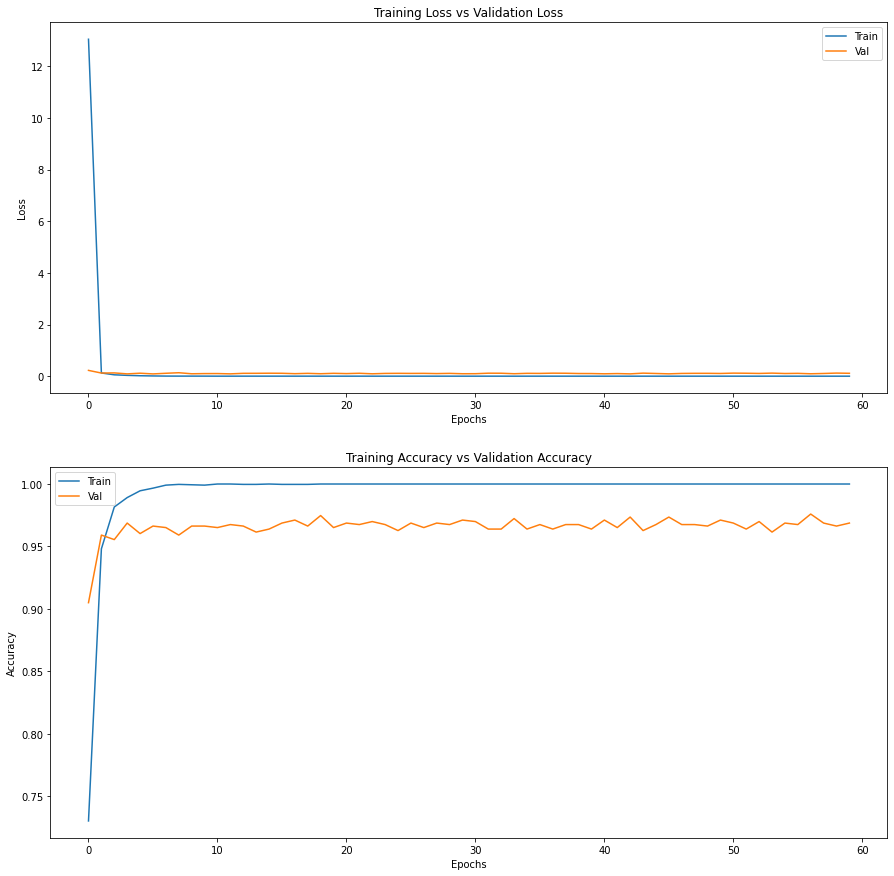

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

### Train and test Xception

In [ ]:
base_model = tf.keras.applications.xception.Xception(weights='imagenet', include_top = False, input_shape =(img_height,img_width,3))
for layer in base_model.layers:
  layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(1000, activation='relu')(x)
predictions = Dense(2, activation = 'softmax')(x)

head_model = Model(inputs = base_model.input, outputs = predictions)
opt = Adam(learning_rate=0.0005)
head_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])



head_model.summary()


83697664/83683744 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                      

In [ ]:
# Let us train the Model 15 times
epochs = 60

steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

# Create a Callback which reduces the Learning rate by a factor of "0.1" when the val_loss does not decrease
# after 2 epochs also and allowing the minimum value of Learning Rate to be 0.00001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=0.00001, mode='auto')


# Create another Callback which saves the Model Weights by monitoring the Val_Accuracy
checkpoint = ModelCheckpoint("model_weights_resnet_128.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)


# A callback is an object that can perform actions at various stages of training
# (e.g. at the start or end of an epoch, before or after a single batch, etc).
callbacks = [checkpoint, reduce_lr]

# Fitting the model .
history = head_model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/60
52/52 [==============================] - ETA: 0s - loss: 38.6987 - accuracy: 0.6294
Epoch 00001: saving model to model_weights_resnet_128.h5
52/52 [==============================] - 54s 794ms/step - loss: 38.6987 - accuracy: 0.6294 - val_loss: 0.9949 - val_accuracy: 0.6827 - lr: 5.0000e-04
Epoch 2/60
52/52 [==============================] - ETA: 0s - loss: 0.5246 - accuracy: 0.7969
Epoch 00002: saving model to model_weights_resnet_128.h5
52/52 [==============================] - 39s 745ms/step - loss: 0.5246 - accuracy: 0.7969 - val_loss: 0.4963 - val_accuracy: 0.8029 - lr: 5.0000e-04
Epoch 3/60
52/52 [==============================] - ETA: 0s - loss: 0.4825 - accuracy: 0.8176
Epoch 00003: saving model to model_weights_resnet_128.h5
52/52 [==============================] - 39s 743ms/step - loss: 0.4825 - accuracy: 0.8176 - val_loss: 0.4004 - val_accuracy: 0.8413 - lr: 5.0000e-04
Epoch 4/60
52/52 [==============================] - ETA: 0s - loss: 0.3975 - accuracy: 0.8420
Epoc